# Stereo Vision

## Imports

In [1]:
import requests
import os

import cv2
import matplotlib.pyplot as plt
import numpy as np

## Utlilities

In [ ]:
def download_file(file_url, file_name):
  video = requests.get(file_url).content
  with open(file_name, 'wb') as handler:
    handler.write(video)
  return os.path.join(os.getcwd(), file_name)

In [ ]:
def plot_grouped_images(images, title):
  num_images = len(images)
  fig, axarr = plt.subplots(1, num_images)

  fig.set_figheight(4)
  fig.set_figwidth(15)

  i = 0
  for k, v in images.items():
    axarr[i].set_title(f'window size = {k}')
    axarr[i].imshow(v * 5, cmap='gray')
    i += 1

  fig.suptitle(title)

## Downloading Images

In [ ]:
base_url = 'https://raw.githubusercontent.com/Youhanna-Yousry/Stereo-Vision/master/assets/'

l1_name = 'l1.png'
l1_path = download_file(base_url + l1_name, l1_name)

r1_name = 'r1.png'
r1_path = download_file(base_url + r1_name, r1_name)

l2_name = 'l2.png'
l2_path = download_file(base_url + l2_name, l2_name)

r2_name = 'r2.png'
r2_path = download_file(base_url + r2_name, r2_name)

l3_name = 'l3.png'
l3_path = download_file(base_url + l3_name, l3_name)

r3_name = 'r3.png'
r3_path = download_file(base_url + r3_name, r3_name)

In [ ]:
BGR_images = {
    'l1': cv2.imread(l1_path),
    'r1': cv2.imread(r1_path),
    'l2': cv2.imread(l2_path),
    'r2': cv2.imread(r2_path),
    'l3': cv2.imread(l3_path),
    'r3': cv2.imread(r3_path)
}

gray_images = {
    'l1': cv2.imread(l1_path, 0),
    'r1': cv2.imread(r1_path, 0),
    'l2': cv2.imread(l2_path, 0),
    'r2': cv2.imread(r2_path, 0),
    'l3': cv2.imread(l3_path, 0),
    'r3': cv2.imread(r3_path, 0)
}

## Stereo Vision

### 1. Block Matching


The Matcing cost function **Sum of Squared Difference**

In [ ]:
def SSD(left_patch, right_patch):
  return np.sum((left_patch - right_patch)**2)

The Matcing cost function **Sum of Absolute Difference**

In [ ]:
def SAD(left_patch, right_patch):
    return np.sum(np.abs(left_patch  - right_patch))

This function is used to compute the disparity map using Block Matching.


***params***


*  **left_image** The image taken by the left camera.

*  **right_image** The image taken by the right_camera.

*  **window_size** The size of the window of pixels to be matched in the left. and right scan lines

*  **matching_cost** The cost function used to match the left and right blocks.

***returns***

*  The normalized disparity map

**steps**

1. At first, we perform padding to both left and right images, so we can match the pixels at the border.

2. Secondly, for each row in the left image we match all pixels of the row to pixels in the corresponding row in the right image.

3. To match the pixels, we match a pixel with its neighbourhood in the left line with all pixels with their neighbours in the right image and select the matching with the minimum cost and store the disparity.

4. Finally, we normalize the disparity map then return it.


In [ ]:
def compute_disparity_map(left_image, right_image, window_size, matching_cost):

    left_image, right_image = left_image.astype(np.float32), right_image.astype(np.float32)
    disparity_map = np.zeros_like(left_image, dtype=np.float32)[:,:,0]

    left_image = np.pad(left_image, ((window_size // 2, window_size // 2), (window_size // 2, window_size // 2), (0, 0)), mode='constant')
    right_image = np.pad(right_image, ((window_size // 2, window_size // 2), (window_size // 2, window_size // 2), (0, 0)), mode='constant')

    height, width = left_image.shape[:2]

    shift = window_size // 2

    for x in range(window_size // 2, height - window_size // 2):
        for y in range(window_size // 2, width - window_size // 2):

            left_patch = left_image[x - shift: x + shift + 1, y - shift: y + shift + 1, :]

            min_cost, disparity = float('inf'), 0

            for p in range(window_size // 2, y):
                right_patch = right_image[x - shift: x + shift + 1, p - shift: p + shift + 1, :]

                cost = matching_cost(left_patch, right_patch)

                if cost == min_cost and np.abs(disparity) > np.abs(y - p):
                    disparity = y - p

                if cost < min_cost:
                    min_cost, disparity = cost, y - p

            disparity_map[x - shift, y - shift] = disparity

    disparity_map = cv2.normalize(disparity_map, None, 0, 255, cv2.NORM_MINMAX)

    disparity_map = disparity_map.astype(np.uint8)

    return disparity_map

In [ ]:
def compute_batched_disparity_map(image_idx, BGR_images, window_sizes, matching_cost):
  dis = {}

  for w in window_sizes:
    dis[f'{w}'] = \
      compute_disparity_map(BGR_images[f'l{image_idx}'], BGR_images[f'r{image_idx}'], window_size = w, matching_cost = matching_cost)

  return dis

In [ ]:
windows_sizes = [1, 5, 9]
images_indexes = [1, 2, 3]

#### I. Image 1

- Sum of Absolute Differences

In [ ]:
dis = compute_batched_disparity_map(images_indexes[0], BGR_images, windows_sizes, SAD)

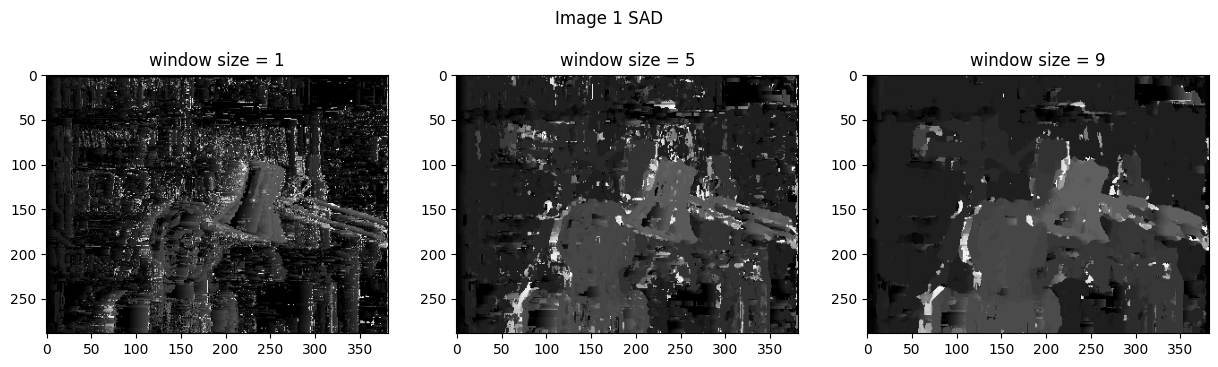

In [ ]:
plot_grouped_images(dis, f"Image {images_indexes[0]} SAD")

- Sum of Squared Differences

In [ ]:
dis = compute_batched_disparity_map(images_indexes[0], BGR_images, windows_sizes, SSD)

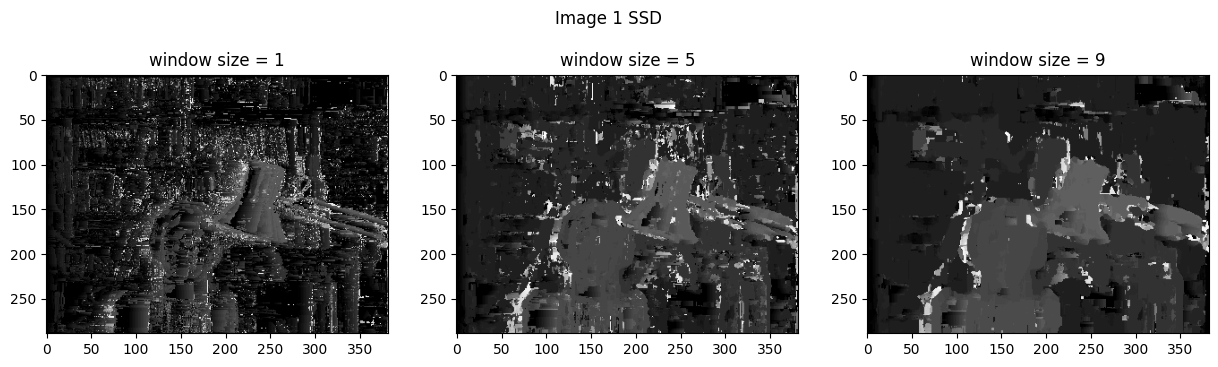

In [ ]:
plot_grouped_images(dis, f"Image {images_indexes[0]} SSD")

#### II. Image 2

- Sum of Absolute Differences

In [ ]:
dis = compute_batched_disparity_map(images_indexes[1], BGR_images, windows_sizes, SAD)

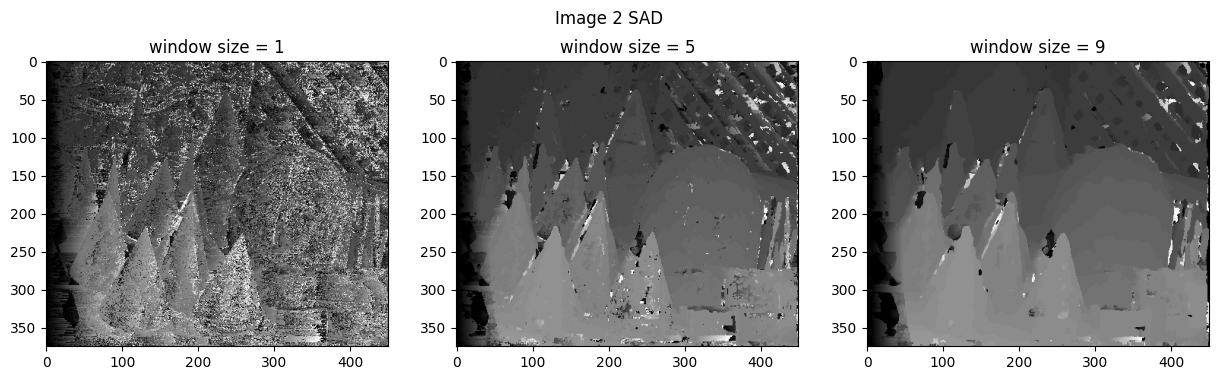

In [ ]:
plot_grouped_images(dis, f"Image {images_indexes[1]} SAD")

- Sum of Squared Differences

In [ ]:
dis = compute_batched_disparity_map(images_indexes[1], BGR_images, windows_sizes, SSD)

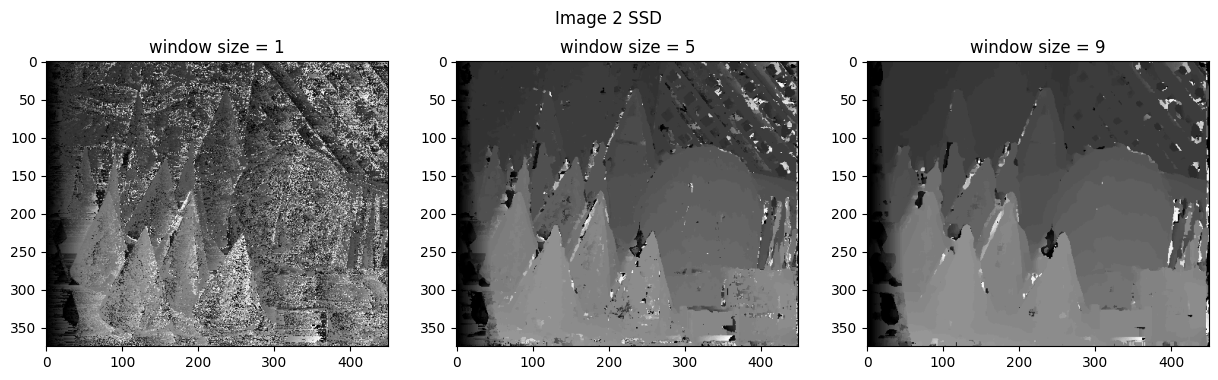

In [ ]:
plot_grouped_images(dis, f"Image {images_indexes[1]} SSD")

#### III. Image 3

- Sum of Absolute Differences

In [ ]:
dis = compute_batched_disparity_map(images_indexes[2], BGR_images, windows_sizes, SAD)

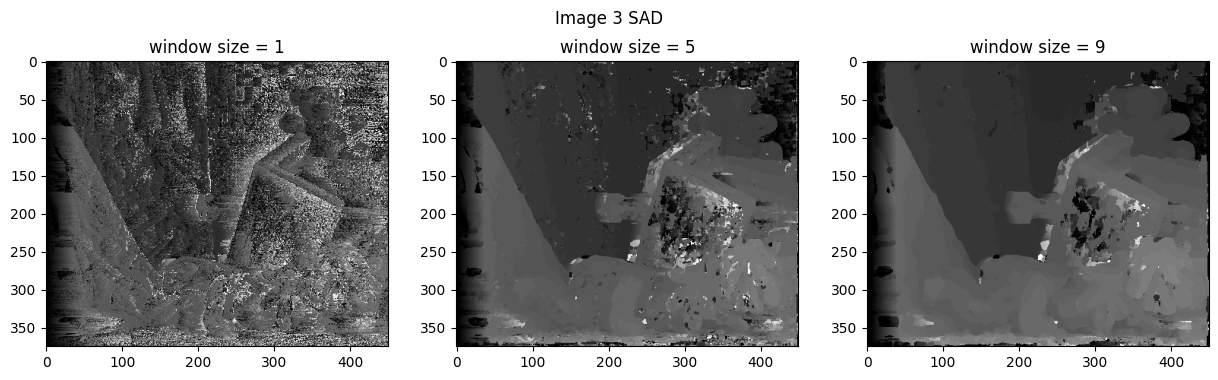

In [ ]:
plot_grouped_images(dis, f"Image {images_indexes[2]} SAD")

- Sum of Squared Differences

In [ ]:
dis = compute_batched_disparity_map(images_indexes[2], BGR_images, windows_sizes, SSD)

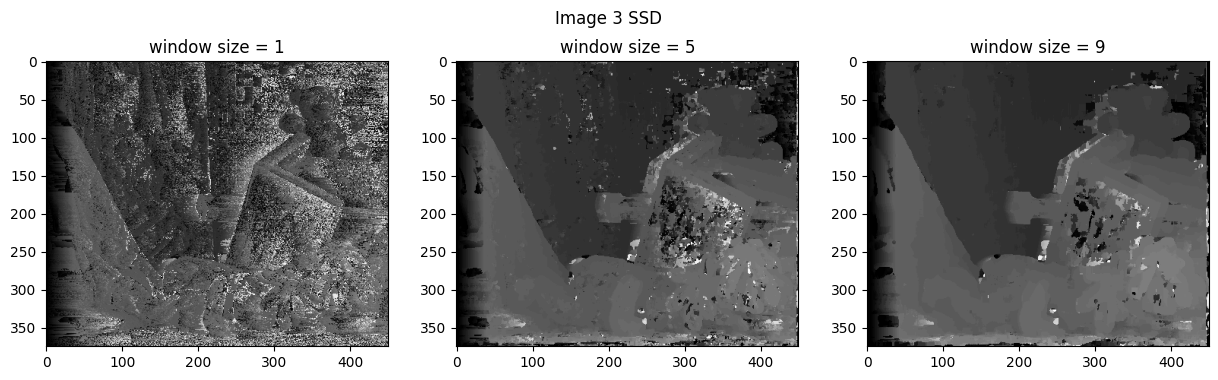

In [ ]:
plot_grouped_images(dis, f"Image {images_indexes[2]} SSD")

### 2. Dynamic Programming


Computes the cost matrix with dynamic programming.

***Parameters***


*  **cost_matrix** Matrix to store computed costs for dynamic programming.
*  **i** Current index in the left line.
*  **j** Current index in the right line.
*  **left_line** Row of pixels of the left line.
*  **right_line** Row of pixels of the right line.

***Returns***


*  Computed cost for the given indices (i, j).

***Steps***

  1. Check if the cost for the current indices (i, j) has already been computed.
  2. If not computed, recursively calculate the cost based on the dynamic programming approach.
  3. Base cases:
       - If at the top-left corner (i=0, j=0), return the squared intensity difference divided by 4.
       - If at (i=0), recursively compute the cost of skipping right line
       - If at (j=0), recursively compute the cost of skipping left line.
  4. For other cases, compute the cost as the minimum of three possibilities:
       - Diagonal move with squared intensity difference divided by 4.
       - Horizontal move with a cost increment of 1.
       - Vertical move with a cost increment of 1.
  5. Store the computed cost in the cost_matrix and return it

  reference: https://www.cse.psu.edu/~rtc12/CSE486/lecture09.pdf

In [ ]:
def compute_cost_matrix(cost_matrix, i, j, left_line, right_line):
  if cost_matrix[i, j] != -1.0:
    return cost_matrix[i, j]

  if i == 0 and j == 0:
    return ((left_line[i] - right_line[j]) ** 2) / 4

  elif i == 0:
    cost_matrix[i, j] = compute_cost_matrix(cost_matrix, i, j - 1, left_line, right_line) + 1.0
    return cost_matrix[i, j]

  elif j == 0:
    cost_matrix[i, j] = compute_cost_matrix(cost_matrix, i - 1, j, left_line, right_line) + 1.0
    return cost_matrix[i, j]

  else:
    cost_matrix[i, j] = np.min([((left_line[i] - right_line[j]) ** 2) / 4 + compute_cost_matrix(cost_matrix, i - 1, j - 1, left_line, right_line),
                   compute_cost_matrix(cost_matrix, i - 1, j, left_line, right_line) + 1.0,
                   compute_cost_matrix(cost_matrix, i, j - 1, left_line, right_line) + 1.0 ])
    return cost_matrix[i, j]

This function is used to fill oclussion by replacing pixels with zero intesnsity with the value of the nearst non zero pixel from left

In [ ]:
def fill_disparity_map(disparity_map, line):
  width = disparity_map.shape[1]

  for col in range(width-1, 0, -1):
    if disparity_map[line, col] == 0:
      non_zeros_idx = np.nonzero(disparity_map[line, :col])[0]
      if non_zeros_idx.size > 0:
        disparity_map[line, col] = disparity_map[line, non_zeros_idx[-1]]

Backtracks to find the disparity map without considering alignment.

***Parameters***

*  **disparity_map** Matrix to store the computed disparity values.
*  **cost_matrix** Matrix storing computed costs from dynamic programming.
*  **line** Current row index in the disparity map.
*  **left_line** Row of pixels in the left image.
*  **right_line** Row of pixels in the right image.

***Steps***

1. Start at the last column of the disparity map.
2. While not at the top-left corner:
       a. Calculate matching cost between pixels in left and right lines.
       b. Choose the minimum cost direction among diagonal, horizontal, and vertical moves.
       c. Update disparity map at the current position with the absolute difference between i and j.
       d. Move pointers based on the chosen minimum cost direction.

In [ ]:
def backtrack_without_alignment(disparity_map, cost_matrix, line, left_line, right_line):
  i, j = disparity_map.shape[1] - 1, disparity_map.shape[1] - 1

  while i >= 0 and j >= 0:
    matching_cost = ((left_line[i] - right_line[j]) ** 2) / 4
    min_val = np.min([cost_matrix[i-1, j-1] + matching_cost, cost_matrix[i-1, j] + 1.0, cost_matrix[i, j-1] + 1.0])

    if min_val == cost_matrix[i-1, j-1] + matching_cost:
        disparity_map[line, i] = abs(i - j)
        i -= 1
        j -= 1
    elif min_val == cost_matrix[i-1, j] + 1.0:
        i -= 1
    else:
        j -= 1

The function performs same as above but store the points to draw the best path for minimum cost

In [ ]:
def backtrack_with_alignment(disparity_map, cost_matrix, line, left_line, right_line):
  i, j = disparity_map.shape[1] - 1, disparity_map.shape[1] - 1
  current_alignments = []

  while i >= 0 and j >= 0:
    matching_cost = ((left_line[i] - right_line[j]) ** 2) / 4
    min_val = np.min([cost_matrix[i-1, j-1] + matching_cost, cost_matrix[i-1, j] + 1.0, cost_matrix[i, j-1] + 1.0])

    current_alignments.append([i, j])

    if min_val == cost_matrix[i-1, j-1] + matching_cost:
        disparity_map[line, i] = abs(i - j)
        i -= 1
        j -= 1
    elif min_val == cost_matrix[i-1, j] + 1:
        i -= 1
    else:
         j -= 1

  while i >= 0:
    current_alignments.append([i, j])
    i -= 1

  while j >= 0:
    current_alignments.append([i, j])
    j -= 1

  return current_alignments

Computes the disparity map using dynamic programming.

***Parameters***

*  **left_image** Image from the left camera.
*  **right_image** Image from the right camera.
*  **compute_alinments** Flag to compute pixel alignments along with the disparity map.
*  **fill_occlusion** Flag to fill occluded regions in the disparity map.

***Returns***

* Disparity map, and optional alignments if compute_alignments is True.

***Steps***

1. Iterate through each row of the images.
2. Create a cost matrix and perform dynamic programming to compute disparity.
3. Backtrack to find disparity without alignment or with alignment based on the flag.
4. Optionally, fill occluded regions in the disparity map.
5. Normalize and convert the disparity map to uint8.
6. Return the disparity map

In [ ]:
def computing_disparity_DP(left_image, right_image, compute_alignments = False, fill_occlusion = True):
    left_image, right_image = left_image.astype(np.float64), right_image.astype(np.float64)

    height, width = left_image.shape[:2]

    disparity_map = np.zeros_like(left_image, dtype=np.float64)

    alignments_found = []

    for line in range(height):
      cost_matrix = np.ones((width, width)).astype(np.float64) * -1.0
      left_line, right_line =  left_image[line, :], right_image[line, :]

      compute_cost_matrix(cost_matrix, width-1, width-1, left_line, right_line)

      i, j = width - 1, width - 1

      if compute_alignments:
        alignments_found.append(backtrack_with_alignment(disparity_map, cost_matrix, line, left_line, right_line))
      else:
        backtrack_without_alignment(disparity_map, cost_matrix, line, left_line, right_line)

      if not fill_occlusion:
        continue

      fill_disparity_map(disparity_map, line)


    disparity_map = cv2.normalize(disparity_map, None, 0, 255, cv2.NORM_MINMAX)

    disparity_map = disparity_map.astype(np.uint8)

    if compute_alignments:
      return disparity_map, alignments_found

    return disparity_map

In [ ]:
disparity_info = {}

disparity_info['left_filled_map_1'], disparity_info['alignments1'] \
  = computing_disparity_DP(gray_images['l1'], gray_images['r1'], compute_alignments=True)

disparity_info['left_map_1'] \
  = computing_disparity_DP(gray_images['l1'], gray_images['r1'], compute_alignments=False, fill_occlusion=False)

disparity_info['left_filled_map_2'], disparity_info['alignments2'] \
  = computing_disparity_DP(gray_images['l2'], gray_images['r2'], compute_alignments=True)

disparity_info['left_map_2'] \
  = computing_disparity_DP(gray_images['l2'], gray_images['r2'], compute_alignments=False, fill_occlusion=False)

disparity_info['left_filled_map_3'], disparity_info['alignments3'] \
  = computing_disparity_DP(gray_images['l3'], gray_images['r3'], compute_alignments=True)

disparity_info['left_map_3'] \
  = computing_disparity_DP(gray_images['l3'], gray_images['r3'], compute_alignments=False, fill_occlusion=False)

#### I. Image 1

- With Occlusion Filling:

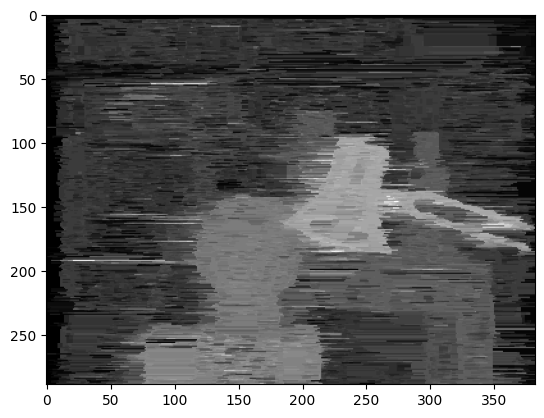

In [ ]:
plt.imshow(disparity_info['left_filled_map_1'], cmap='gray')

- Without Occlusion Filling:

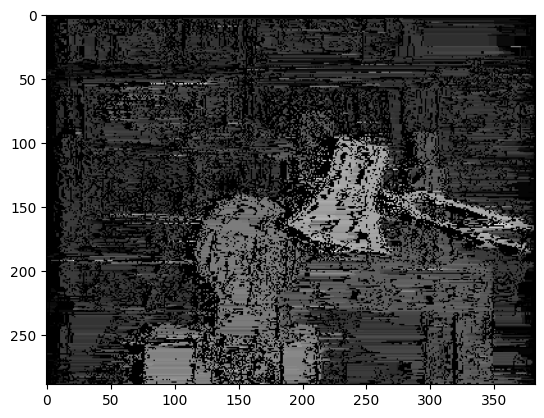

In [ ]:
plt.imshow(disparity_info['left_map_1'], cmap='gray')

#### II. Image 2

- With Occlusion Filling:

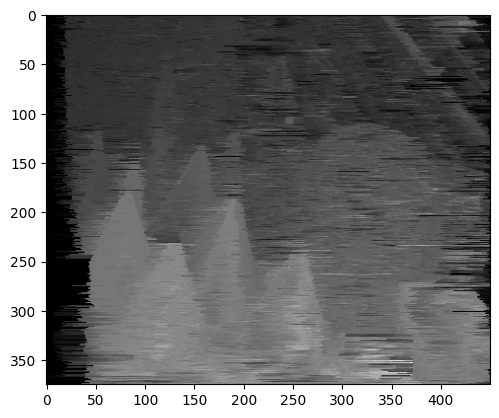

In [ ]:
plt.imshow(disparity_info['left_filled_map_2'], cmap='gray')

- Without Occlusion Filling:

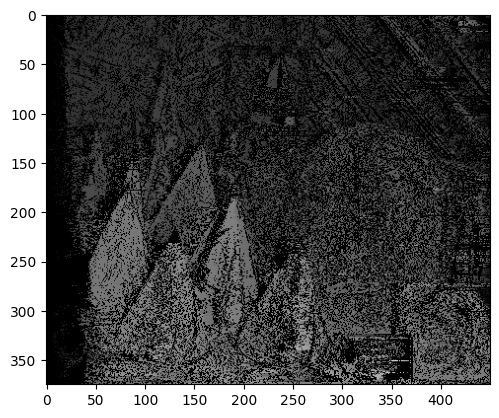

In [ ]:
plt.imshow(disparity_info['left_map_2'], cmap='gray')

#### III. Image 3

- With Occlusion fill:

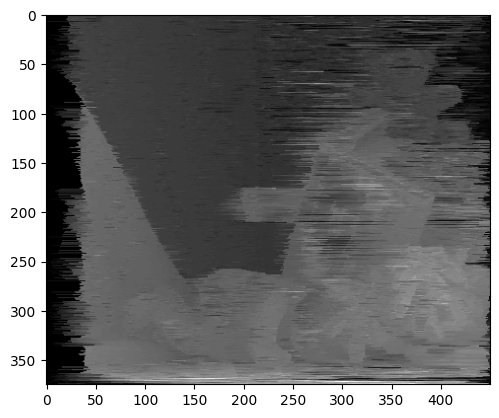

In [ ]:
plt.imshow(disparity_info['left_filled_map_3'], cmap='gray')

- Without Occlusion Fill:

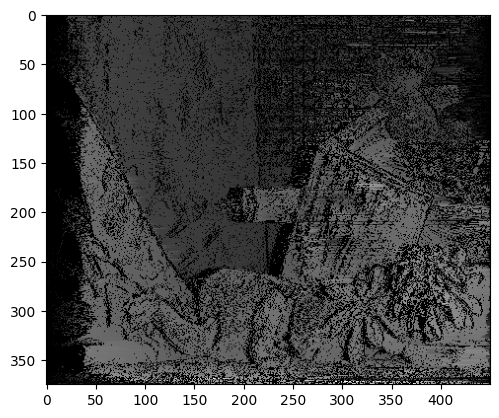

In [ ]:
plt.imshow(disparity_info['left_map_3'], cmap='gray')

## Bonus

This function is used to draw the path with the minumum cost for matching the left and right line

In [ ]:
def draw_alignment_with_pixels(alignments, img_left, img_right, line_idx):
    img_left_normalized = cv2.cvtColor(img_left, cv2.COLOR_BGR2RGB) / 255.0
    img_right_normalized = cv2.cvtColor(img_right, cv2.COLOR_BGR2RGB) / 255.0

    selected_alignments = alignments[line_idx]
    x_values, y_values = zip(*selected_alignments)

    plt.plot(x_values, y_values, linestyle='-', linewidth=0.5, color='red')

    img_left_line = img_left_normalized[line_idx]
    img_right_line = img_right_normalized[line_idx]

    width = len(img_left_line)

    plt.scatter(np.arange(width), np.zeros(width) - 15, c=img_left_line, marker='s')

    plt.scatter(np.zeros(width) - 15, np.arange(width), c=img_right_line, marker='s')

    plt.gca().invert_yaxis()

    plt.xlabel(f'Line {line_idx} of right picture')
    plt.ylabel(f'Line {line_idx} of left picture')

    plt.show()

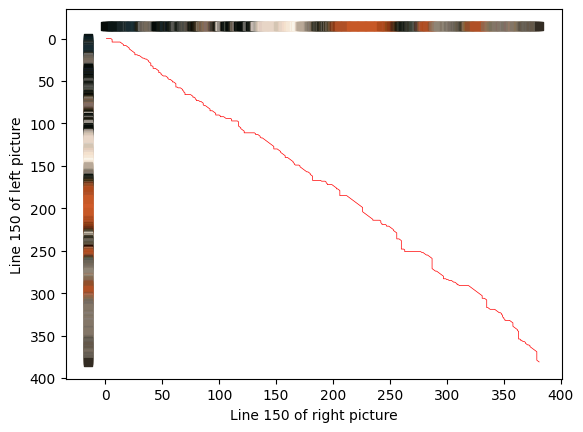

In [ ]:
draw_alignment_with_pixels(disparity_info['alignments1'], BGR_images['l1'], BGR_images['r1'], 150)

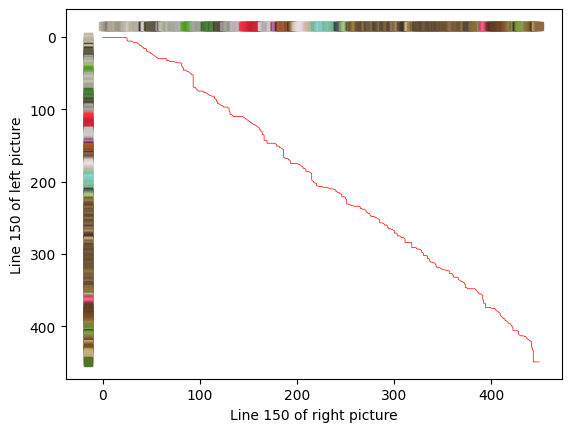

In [ ]:
draw_alignment_with_pixels(disparity_info['alignments2'], BGR_images['l2'], BGR_images['r2'], 150)

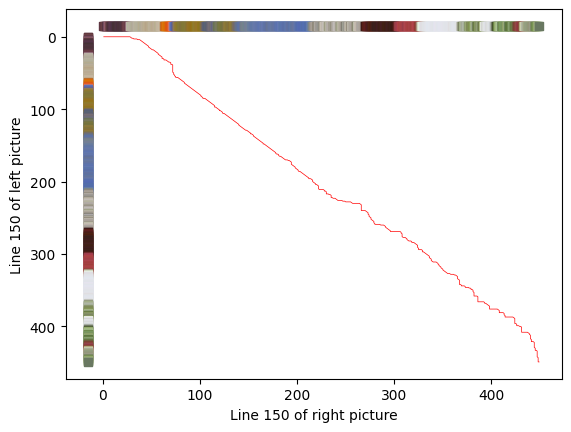

In [ ]:
draw_alignment_with_pixels(disparity_info['alignments3'], BGR_images['l3'], BGR_images['r3'], 150)